In [1]:
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from models import utils, parser_ops, UnrollNet
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
parser = parser_ops.get_parser()
args = parser.parse_args(args=[])

### Plot loss curves

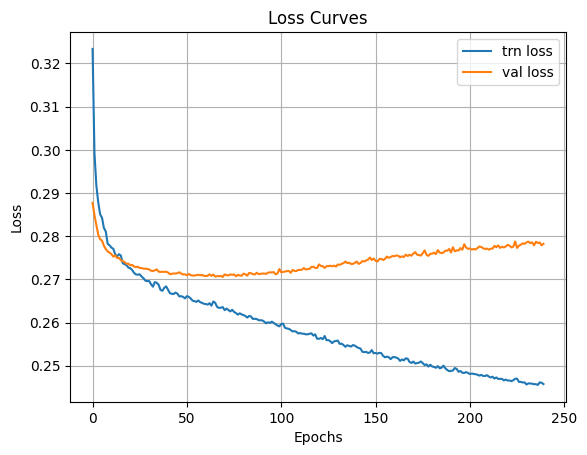

In [2]:
file_dir = os.path.join(os.getcwd(),'saved_models')
saved_model_dir = os.path.join(file_dir,args.saved_model_name)
trn_loss=sio.loadmat(os.path.join(saved_model_dir,'TrainingLog.mat'))['trn_loss']
val_loss=sio.loadmat(os.path.join(saved_model_dir,'TrainingLog.mat'))['val_loss']
plt.plot(np.asarray(trn_loss).T)
plt.plot(np.asarray(val_loss).T)
plt.title('Loss Curves'), plt.xlabel('Epochs'), plt.ylabel('Loss')
plt.legend(['trn loss', 'val loss'])
plt.grid()
plt.show()

### Load the data and generate images

In [3]:
# load the data, pad the mask and normalize k-space
data = sio.loadmat(args.data_dir) 
kspace_test,sens_maps, original_mask= data['kspace'], data['sens_maps'], data['mask']
nrow_GLOB, ncol_GLOB, ncoil_GLOB  = kspace_test.shape

# %%  zeropadded outer edges of k-space with no signal- check readme file for further explanations
# for coronal PD dataset, first 17 and last 16 columns of k-space has no signal
# in the training mask we set corresponding columns as 1 to ensure data consistency
test_mask = np.complex64(original_mask)
if args.data_opt=='Coronal_PD':
    test_mask[ :, 0:17] = np.ones((nrow_GLOB, 17))
    test_mask[:, 352:ncol_GLOB] = np.ones((nrow_GLOB, 16))
    
# Normalize the kspace to 0-1 region
kspace_test= kspace_test / np.max(np.abs(kspace_test[:]))

#generate network input and reference image
nw_input = utils.sense1(kspace_test * np.tile(test_mask[..., np.newaxis], (1, 1, ncoil_GLOB)),sens_maps)
ref_image = utils.sense1(kspace_test,sens_maps)

### Load the model and perform the reconstruction

In [4]:
model =UnrollNet.UnrolledNet(args,device=device).to(device)
model.load_state_dict(torch.load(os.path.join(saved_model_dir,'best.pth'))["model_state"])

model.eval()
with torch.no_grad():
    sens_maps  = torch.from_numpy(np.transpose(sens_maps[np.newaxis], (0, 3, 1, 2))).to(device)
    input_to_nw = torch.from_numpy(utils.complex2real(nw_input)[np.newaxis]).permute(0,3,1,2).to(device)
    trn_mask = torch.from_numpy(test_mask[np.newaxis]).to(device)
    nw_img_output, lamdas,nw_kspace_output = model(input_to_nw,trn_mask,trn_mask,sens_maps)

zs_ssl_recon = utils.real2complex(nw_img_output.permute(0,2,3,1).squeeze().to('cpu').numpy())

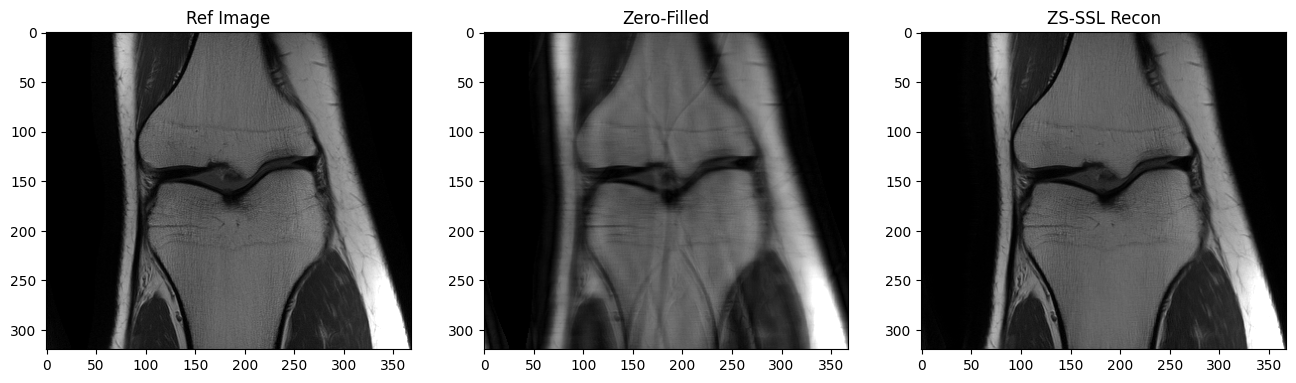

In [5]:
if args.data_opt == 'Coronal_PD':
    """window levelling in presence of fully-sampled data"""
    factor = np.max(np.abs(ref_image[:]))
else:
    factor = 1

ref_image = np.abs(ref_image) / factor
nw_input = np.abs(nw_input) / factor
zs_ssl_recon = np.abs(zs_ssl_recon) / factor

plt.figure(figsize=(16,16))
plt.subplot(1,3,1),plt.imshow(ref_image,cmap='gray',vmax=0.6*np.max(ref_image[:])), plt.title('Ref Image')
plt.subplot(1,3,2),plt.imshow(nw_input,cmap='gray',vmax=0.6*np.max(ref_image[:])), plt.title('Zero-Filled')
plt.subplot(1,3,3),plt.imshow(zs_ssl_recon,cmap='gray',vmax=0.6*np.max(ref_image[:])), plt.title('ZS-SSL Recon')
plt.show()